<a href="https://colab.research.google.com/github/frozenparadox99/Pytorch-Grad-CAM/blob/main/PytorchGradCamWithImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import cv2

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
import os
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/prep_data"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TEST_COVID  TRAIN_COVID		   TRAIN_COVID_RESIZE  TRAIN_NON_AUGMENTED
TEST_NON    TRAIN_COVID_AUGMENTED  TRAIN_NON	       TRAIN_NON_RESIZE


In [13]:
train_data_path_covid = '/content/drive/My Drive/prep_data/TRAIN_COVID/'
train_data_path_non_covid = '/content/drive/My Drive/prep_data/TRAIN_NON/'

In [22]:
# Define the dataset class
class COVIDDataset(Dataset):
    def __init__(self, data_path_label_1, data_path_label_2,transform=None):
        self.transform = transform
        self.data = []
        

        for filename in os.listdir(data_path_label_1):
          if '.png' in filename:
            final_path = data_path_label_1 + filename
            self.data.append((final_path, 1))
        
        for filename in os.listdir(data_path_label_2):
          if '.png' in filename:
            final_path = data_path_label_2 + filename
            self.data.append((final_path, 0))
        
       
    def __getitem__(self, index):
        img_path, label = self.data[index]
        img = Image.open(img_path).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.data)

In [5]:
class COVIDNet(nn.Module):
    def __init__(self, num_classes=2):
        super(COVIDNet, self).__init__()
        self.model = models.resnet18(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

In [6]:
def GradCam(image, model, target_layer):
    model.eval()
    feature_map, output = model(image)
    one_hot = torch.zeros((1, output.size()[-1]), dtype=torch.float32, device=device)
    one_hot[0][torch.argmax(output)] = 1
    one_hot.requires_grad_(True)
    model.zero_grad()
    one_hot.backward()
    grads = torch.mean(model.get_activations_gradient()[target_layer], axis=(2, 3))
    feature_map = model.get_activations()[target_layer]
    feature_weights = torch.nn.functional.adaptive_avg_pool2d(grads, 1)
    cam = torch.multiply(feature_map, feature_weights.unsqueeze(-1).unsqueeze(-1)).sum(1).unsqueeze(0)
    cam = torch.nn.functional.relu(cam)
    cam = cam - torch.min(cam)
    cam = cam / torch.max(cam)
    return cam

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [23]:
train_dataset = COVIDDataset(train_data_path_covid, train_data_path_non_covid,transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)

In [24]:
model = COVIDNet(num_classes=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [25]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()

In [27]:
model.eval()
correct = 0
total = 0
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate the accuracy and other metrics
accuracy = 100 * correct / total
confusion_matrix = np.zeros((2, 2), dtype=np.int64)
for t, p in zip(y_true, y_pred):
    confusion_matrix[t, p] += 1
precision = confusion_matrix[1, 1] / np.sum(confusion_matrix[:, 1])
recall = confusion_matrix[1, 1] / np.sum(confusion_matrix[1, :])
f1_score = 2 * precision * recall / (precision + recall)

print('Accuracy:', accuracy)
print('Confusion matrix:', confusion_matrix)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1_score)

Accuracy: 97.89156626506023
Confusion matrix: [[335  13]
 [  1 315]]
Precision: 0.9603658536585366
Recall: 0.9968354430379747
F1 score: 0.9782608695652173


In [45]:
model

COVIDNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [37]:
image_path = '/content/drive/My Drive/prep_data/TRAIN_COVID/1.png'
img = Image.open(image_path).convert('RGB')
img_tensor = transform(img).unsqueeze(0)
img_tensor.requires_grad_()
output = model(img_tensor)
_, pred = torch.max(output, 1)
pred_class = pred.item()
score = output[:, pred_class]
model.zero_grad()
score.backward()

In [41]:
output

tensor([[-1.7410,  3.3886]], grad_fn=<AddmmBackward0>)

In [42]:
pred_class

1

In [51]:
test_data_path_covid = '/content/drive/My Drive/prep_data/TEST_COVID/'
test_data_path_non_covid = '/content/drive/My Drive/prep_data/TEST_NON/'

In [52]:
test_dataset = COVIDDataset(test_data_path_covid, test_data_path_non_covid,transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=4)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [53]:
model.eval()
correct = 0
total = 0
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate the accuracy and other metrics
accuracy = 100 * correct / total
confusion_matrix = np.zeros((2, 2), dtype=np.int64)
for t, p in zip(y_true, y_pred):
    confusion_matrix[t, p] += 1
precision = confusion_matrix[1, 1] / np.sum(confusion_matrix[:, 1])
recall = confusion_matrix[1, 1] / np.sum(confusion_matrix[1, :])
f1_score = 2 * precision * recall / (precision + recall)

print('Accuracy:', accuracy)
print('Confusion matrix:', confusion_matrix)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1_score)

Accuracy: 90.0
Confusion matrix: [[43  7]
 [ 3 47]]
Precision: 0.8703703703703703
Recall: 0.94
F1 score: 0.9038461538461539


In [54]:
pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38262 sha256=969372ea423b674e33c86683cf0d983ce85850a41cfc68217a65cbfc1ce8c446
  Stored in directory: /root/.cache/pip/wheels/9b/ae/bd/221d138b169c4867b2ae5c893474d0b23bae6e4750bc95bc55
Successfully built grad-cam


In [79]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

model_2 = resnet50(pretrained=True)
target_layers = [model_2.layer4[-1]]
image_path = '/content/drive/My Drive/prep_data/TRAIN_COVID/1.png'
img = Image.open(image_path).convert('RGB')
img_tensor = transform(img).unsqueeze(0)
img_tensor.requires_grad_()
input_tensor = img_tensor

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model_2, target_layers=target_layers)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

# targets = [ClassifierOutputTarget(281)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
# grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = cam(input_tensor=input_tensor)

# In this example grayscale_cam has only one image in the batch:
# grayscale_cam = grayscale_cam[0, :]


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [89]:
grayscale_cam.shape

(1, 224, 224)

In [90]:
img_grey = np.squeeze(grayscale_cam)

In [91]:
import matplotlib.pyplot as plt

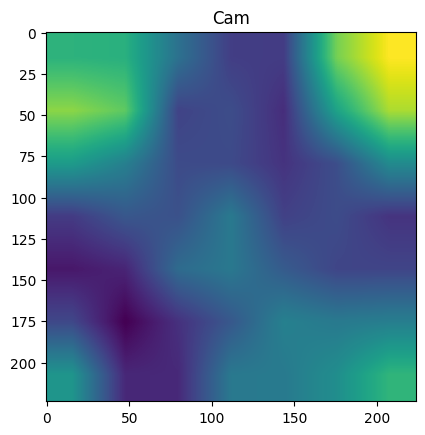

In [94]:
fig, (ax1) = plt.subplots(1, 1)

ax1.imshow(img_grey)
ax1.set_title("Cam")
plt.show()

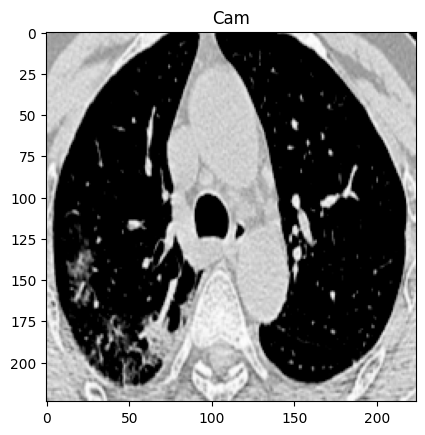

In [101]:
fig, (ax1) = plt.subplots(1, 1)
img_345 = np.transpose(transform(img), (1, 2, 0))
ax1.imshow(img_345)
ax1.set_title("Cam")
plt.show()

In [100]:
img.size

(580, 335)

In [102]:
model_2

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [103]:
model

COVIDNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn